<h1>Stock Market Price Prediction</h1>

<h3> Question </h3>
Can we use a stock market value API to predict future prices for the Tesla stock the use of XGBoost and LSTM deep learning?

<h2> Packages </h2>

In [ ]:
# Load in required packages
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# For ignoring warnings
import warnings
warnings.filterwarnings('ignore')

<h2> Analysis </h2>

In [41]:
# Connect with Stock market API and create DataFrame.
    # Use 60 minute intervals and Tesla stock.
    # Transpose the data for simplification and easy reading.
url = url = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=TSLA&interval=5min&apikey=4DRQ3QJQN5FVYRA9'
r = requests.get(url)
data = r.json()

data = data['Time Series (5min)']
df = pd.DataFrame(data)

df = df.T.reset_index()

df

,index,1. open,2. high,3. low,4. close,5. volume
0,2025-02-07 19:55:00,357.5700,357.9000,357.3200,357.3800,82850
1,2025-02-07 19:50:00,357.3550,357.6000,357.3200,357.5700,40141
2,2025-02-07 19:45:00,357.4900,357.6700,357.3200,357.3400,38025
3,2025-02-07 19:40:00,357.7000,357.7700,357.4400,357.4900,38772
4,2025-02-07 19:35:00,357.7700,357.9000,357.6100,357.7700,25311
...,...,...,...,...,...,...
95,2025-02-07 12:00:00,367.5300,367.5300,366.3000,367.1535,856537
96,2025-02-07 11:55:00,367.7300,369.2277,367.2100,367.6300,652993
97,2025-02-07 11:50:00,367.3000,368.6300,367.2400,367.7250,478239
98,2025-02-07 11:45:00,368.0450,368.8500,367.0300,367.3000,669519


In [42]:
# Rename the column names to remove excess digits and 'index' label.
df = df.rename(columns={"index": "DateTime", '1. open': 'open', '2. high': 'high', '3. low': 'low', '4. close': 'close', '5. volume': 'volume'})

In [43]:
# Examine the data.
    # Check data types, nulls, duplicates, etc.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  100 non-null    object
 1   open      100 non-null    object
 2   high      100 non-null    object
 3   low       100 non-null    object
 4   close     100 non-null    object
 5   volume    100 non-null    object
dtypes: object(6)
memory usage: 4.8+ KB


In [44]:
# Change data types from object to float.

df = df.astype({'open': float, 'high': float, 'low': float, 'close': float, 'volume': int})

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DateTime  100 non-null    object 
 1   open      100 non-null    float64
 2   high      100 non-null    float64
 3   low       100 non-null    float64
 4   close     100 non-null    float64
 5   volume    100 non-null    int32  
dtypes: float64(4), int32(1), object(1)
memory usage: 4.4+ KB


In [45]:
df.duplicated().sum()

0

In [46]:
df.isnull().sum()

DateTime    0
open        0
high        0
low         0
close       0
volume      0
dtype: int64

Through inital exploration, I have found no duplciated or null values, and each data type is currently 'object' and will require changing for further mathematical use.

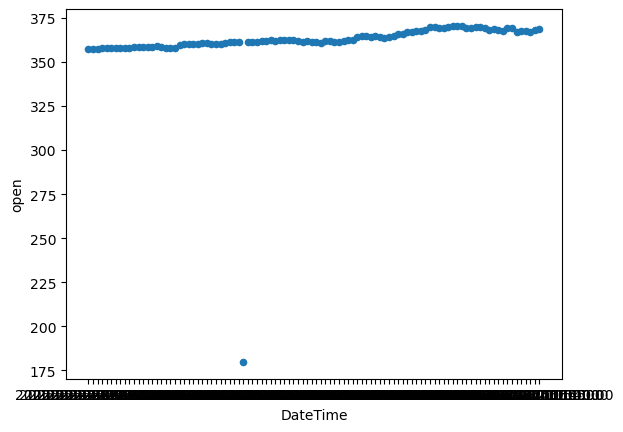

In [47]:
df.plot(x='DateTime', y='open', kind='scatter');

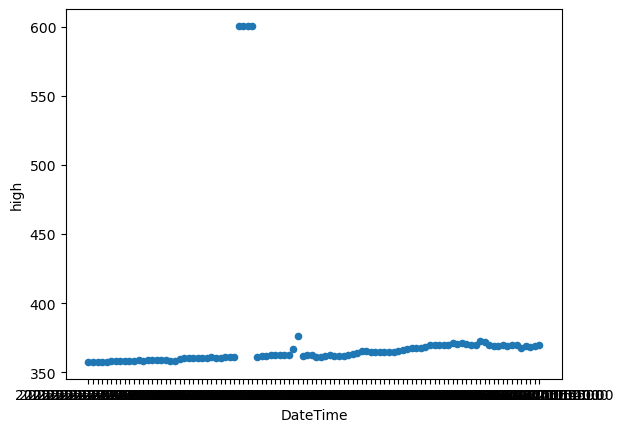

In [48]:
df.plot(x='DateTime', y='high', kind='scatter');

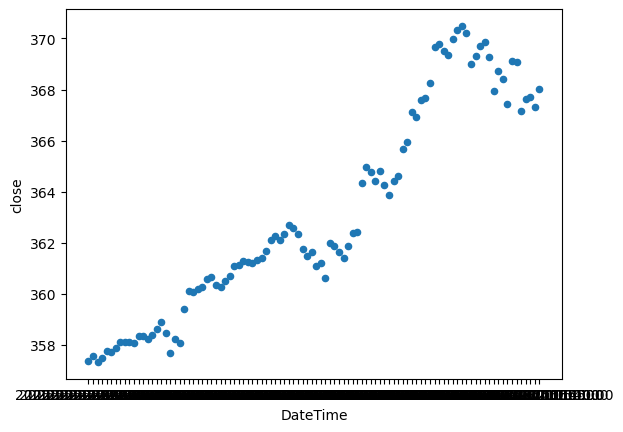

In [49]:
df.plot(x='DateTime', y='close', kind='scatter');

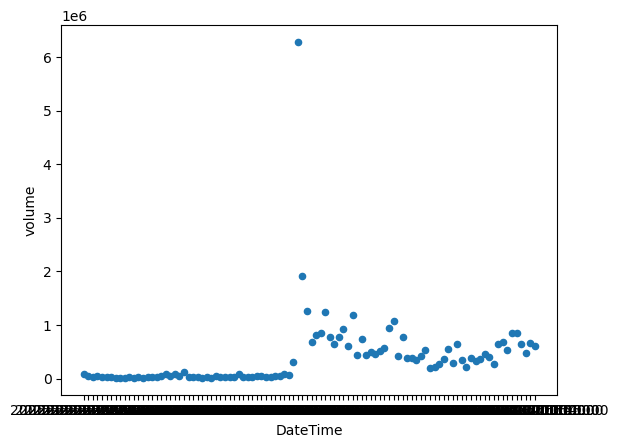

In [50]:
df.plot(x='DateTime', y='volume', kind='scatter');

In [51]:
# Split the data into test and train sets.
features = ['open', 'high', 'low', 'volume']
target = ['close']

X = df[features]
y = df[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

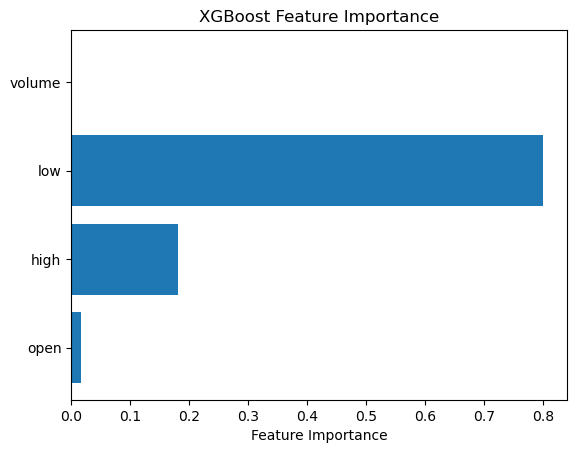

In [52]:
# Train XGBoost Model
xgb_model = XGBRegressor()
xgb_model.fit(X_train_scaled, y_train)

# Feature importance plot
importances = xgb_model.feature_importances_
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.show()

In [53]:
# Reshape data fro LSTm (3D: samples, timesteps, features)
X_train_lstm = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [54]:
# Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train_lstm, y_train, epochs=50, batch_size=16, validation_data=(X_test_lstm, y_test))

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 130723.3281 - val_loss: 135977.1562
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 130909.3438 - val_loss: 135907.5781
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 130863.2969 - val_loss: 135822.5000
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 130428.1250 - val_loss: 135713.2031
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 130642.0234 - val_loss: 135568.6719
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 130435.1484 - val_loss: 135374.7031
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 130197.3438 - val_loss: 135110.6406
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 129693.7344 - val_loss: 134749.9219
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 129486.3281 - val_loss: 134258.2188
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 128820.9844 - val_loss: 133590.6250
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 128547.7734

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


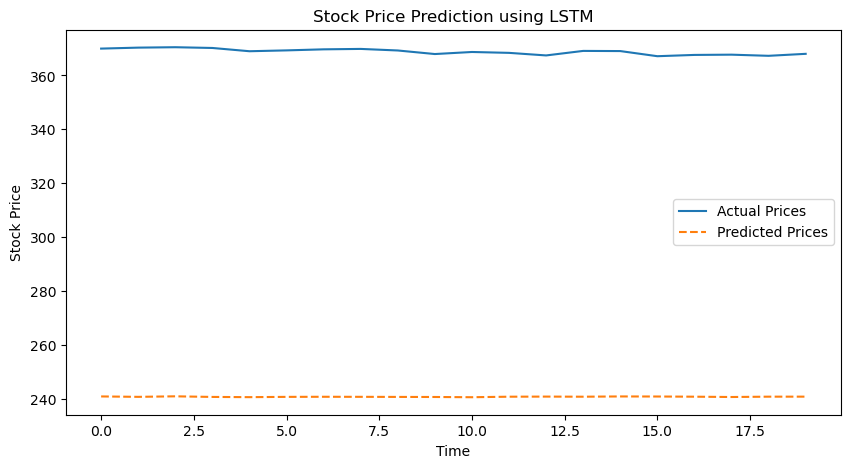

In [55]:
# Predict on test data
y_pred=model.predict(X_test_lstm)

# Reverse Scaling
y_pred = np.array(y_pred).reshape(-1, 1)

# Plot Predictions vs Actual Prices
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Actual Prices")
plt.plot(y_pred, label="Predicted Prices", linestyle='dashed')
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.title("Stock Price Prediction using LSTM")
plt.show()